In [312]:
from  matplotlib import pyplot as plt 
import numpy as np 
from scipy import ndimage as ndim , signal 
from  skimage import filters , feature

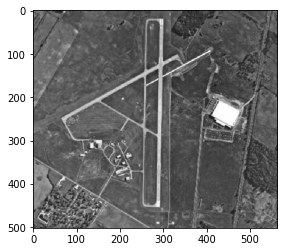

In [313]:
f = plt.imread("./../images/airport.tif")
plt.imshow(f , "gray")

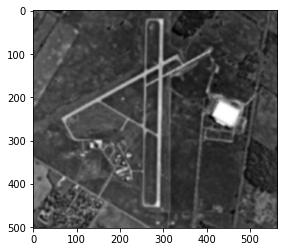

In [314]:
# Gauss Blur 
f = f.copy()
g = ndim.gaussian_filter(f , sigma =2)

plt.imshow(g,"gray")

In [315]:
# 计算 x,y方向上的梯度
def gradient(f):
    
    gradient_x_kernel = np.array ([   

    [
        -1, 0, 1
    ],[
        -2,0,2
    ],[
        -1,0,1
    ]
    ])
    gx = signal.convolve2d(f,gradient_x_kernel)

    gradient_y_kernel = np.array([     
    [
        -1 , -2 , -1
    ],[
        0 , 0 , 0
    ],[
       1, 2, 1
    ]
    ])

    gy =  signal.convolve2d(f,gradient_y_kernel)
    """
    gx = filters.sobel_h(f)
    gy = filters.sobel_v(f)
    """
    return gx ,gy

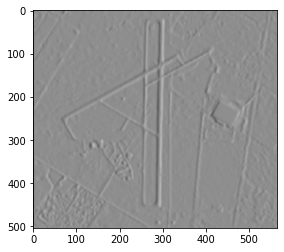

In [316]:
gx, gy = gradient(g)
plt.imshow(gx , 'gray')

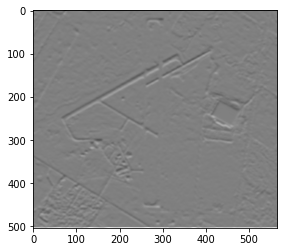

In [317]:
plt.imshow(gy , "gray")

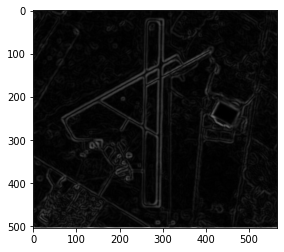

In [318]:
# 幅度图
def magnitude(gx , gy):   
    m = np.abs(gx) + np.abs(gy)
    return m 
m = magnitude(gx , gy)
m = m / m.max() * 255
m.astype(np.uint8)
plt.imshow(m , "gray")

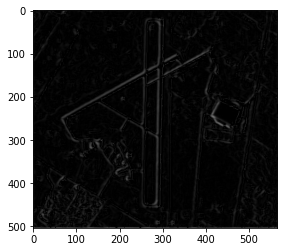

In [319]:

"""
tan 算出梯度方向
"""
def direction (gx,gy):    
    return np.arctan2(gx,gy)

# 非极大化抑制    
def non_max_suppression(m , d):
    h,w = m.shape 
    res = np.zeros([h,w])    
    piece = np.pi / 8
    for y in range(1,h-1):
        for x in range(1,w-1):
            theta = d[y][x]
            current  = m[y][x]
            before = 0 
            after = 0      
            if 0 <= theta < piece or 6 * piece <= theta < np.pi:
                before = m[y -1][x]
                after = m [y+1][x]
            if piece <= theta < piece * 3:
                before = m [y+1][x - 1]
                after = m[y-1][x + 1]
            if piece * 3 <= theta < piece  * 5:
                before = m[y][x-1]
                after = m[y][x + 1]
            if 5 * piece <= theta < 7 * piece:
                before = m[y+1][x+1]
                after = m [y-1][x-1]
            """       
            if 0 <= theta < piece or 6 * piece <= theta < np.pi:
                before = m[y][x -1 ]
                after = m[y][x + 1]
            if piece <= theta < piece * 3:
                before = m[y + 1] [x - 1]
                after = m[y-1][x + 1]
            if piece * 3 <= theta < piece  * 5:
                before = m[y-1][x]
                after = m[y+1][x]
            if  5 * piece <= theta < 7 * piece:
                before = m[y-1][x-1]
                after = m[y+1][x+1]
            """

            if current >= after and current >= before:
                 res[y][x] = current
            else : 
                res[y][x] = 0
    return res

d = direction(gx,  gy)

nm = non_max_suppression(m,d)
plt.imshow(nm , "gray")

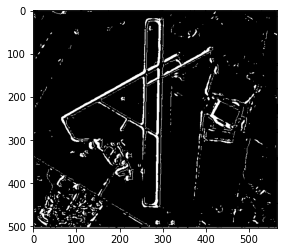

In [320]:
## 双门限处理
def threshold(g , low_threshold_ratio = 0.1 , high_threshold_radio = 0.2 , weak = 25, strong=255):
    high_threshold = g.max() * high_threshold_radio
    low_threshold = g.max() * low_threshold_ratio
    res = np.zeros(g.shape)  
    strong_y , strong_x = np.where(g > high_threshold)
    zeros_y , zeros_x = np.where(g < low_threshold)
    weak_y , weak_x = np.where((g <= high_threshold) & (g>=low_threshold))
    res[strong_y,strong_x] = strong
    res[weak_y , weak_x] = weak
    res[zeros_y , zeros_x] = 0
    return res 

res = threshold(nm , weak = 16 ,strong=16, high_threshold_radio = 0.2 , low_threshold_ratio = 0.1)
plt.imshow(res,"gray" )


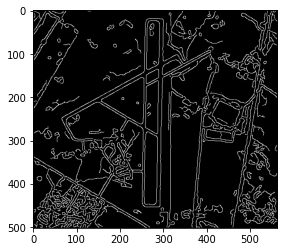

In [321]:
 
edges = feature.canny(f,sigma = 2,low_threshold=0.1 )

plt.imshow(edges , "gray")

In [ ]:
可以看出 自己的算法和 skimage包的结果是不太一样。
在我们得出的结果中 ， 还可以在作一步细化的动作。

## 总结
1. 使用一个高斯滤波器平滑输入图像
2. 计算梯度幅度图像和角度图像
3. 对梯度幅图图像进行非最大化抑制
4. 使用双阈值处理和连同性分析来检测与连接边缘

(尽管非最大抑制的边缘比原始梯度边缘细，但任大于1px。为得到1px粗的边缘。通常要在步骤4执行一次细化算法)